In [1]:
%%capture
%load_ext autoreload
%autoreload 2
from setup_nb_env import *

DATA_DIR = '/work/users/k/4/k4thryn/Repos/EpSampling/data/'
DT = datetime.today().strftime('%Y%m%d-%H%M%S')

In [2]:
ts = '20241108-123515'

fpath = os.path.join(DATA_DIR,'processed',f'training_target_df_{ts}.csv')
df = pd.read_csv(fpath)
# drop nans
df.dropna(inplace=True)
fpath = os.path.join(DATA_DIR,'processed',f'training_acs_df_{ts}.csv')
df_acs = pd.read_csv(fpath)
df_acs.set_index('Fips',inplace=True,drop=True)
# standardize
df_acs = (df_acs-df_acs.mean()) / df_acs.std()

### <font color=blue> Transform target (and target-affecting) variables.

In [3]:
county_transform = [x for x in df.columns if x.startswith('True_county_inc_deaths')]
county_transform += ['Naive_proj_deaths','Naive_true_deaths']
for var in county_transform:
    df[f'{var}_x'] = df.apply(lambda x: (x[var]+1) / x.Pop * 100000, axis=1)
    
state_transform = ['Proj_state_inc_deaths','True_state_inc_deaths']
for var in state_transform:
    df[f'{var}_x'] = df.apply(lambda x: (x[var]+1) / x.State_pop * 100000, axis=1)
    
display(df)

# add in census features
df = df.merge(df_acs,on='Fips')

,Date,State_fips,Fips,Pop,State_pop,Ratio,Proj_state_inc_deaths,True_state_inc_deaths,True_county_cum_deaths,True_county_inc_deaths,...,True_county_inc_deaths_tm_6_x,True_county_inc_deaths_tm_7_x,True_county_inc_deaths_tm_8_x,True_county_inc_deaths_tm_9_x,True_county_inc_deaths_tm_10_x,True_county_inc_deaths_tm_11_x,Naive_proj_deaths_x,Naive_true_deaths_x,Proj_state_inc_deaths_x,True_state_inc_deaths_x
11,20200905,37,37001,169185,10367022,0.016320,157.0,205.0,46.0,0.0,...,1.182138,1.773207,0.591069,1.182138,1.182138,2.364276,2.105486,2.568493,1.524064,1.987070
12,20200912,37,37001,169185,10367022,0.016320,176.0,160.0,48.0,2.0,...,1.182138,1.182138,1.773207,0.591069,1.182138,1.182138,2.288760,2.134424,1.707337,1.553001
13,20200919,37,37001,169185,10367022,0.016320,157.0,187.0,48.0,0.0,...,0.591069,1.182138,1.182138,1.773207,0.591069,1.182138,2.105486,2.394866,1.524064,1.813443
14,20200926,37,37001,169185,10367022,0.016320,171.0,198.0,54.0,6.0,...,1.182138,0.591069,1.182138,1.182138,1.773207,0.591069,2.240530,2.500971,1.659107,1.919548
15,20201003,37,37001,169185,10367022,0.016320,171.0,189.0,56.0,2.0,...,1.773207,1.182138,0.591069,1.182138,1.182138,1.773207,2.240530,2.414158,1.659107,1.832735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9895,20220409,37,37199,18357,10367022,0.001771,55.0,43.0,51.0,0.0,...,5.447513,10.895026,10.895026,21.790053,10.895026,38.132592,5.978042,5.862290,0.540174,0.424423
9896,20220416,37,37199,18357,10367022,0.001771,41.0,76.0,51.0,0.0,...,10.895026,5.447513,10.895026,10.895026,21.790053,10.895026,5.842998,6.180607,0.405131,0.742740
9897,20220423,37,37199,18357,10367022,0.001771,60.0,29.0,51.0,0.0,...,5.447513,10.895026,5.447513,10.895026,10.895026,21.790053,6.026272,5.727246,0.588404,0.289379
9898,20220430,37,37199,18357,10367022,0.001771,33.0,42.0,51.0,0.0,...,5.447513,5.447513,10.895026,5.447513,10.895026,10.895026,5.765830,5.852644,0.327963,0.414777


### <font color=blue> How does training set size affect performance?

_Choose base "predictive" attributes_

In [27]:
# df.columns[:15]

In [44]:
# BASE_PRED_COLS = ['True_state_inc_deaths_x']
BASE_PRED_COLS = [x for x in df.filter(regex='True_county_inc_deaths_tm_._x').columns]
BASE_PRED_COLS += ['True_state_inc_deaths_x']
# BASE_PRED_COLS += ['Naive_proj_deaths']

display(BASE_PRED_COLS)

['True_county_inc_deaths_tm_4_x',
 'True_county_inc_deaths_tm_5_x',
 'True_county_inc_deaths_tm_6_x',
 'True_county_inc_deaths_tm_7_x',
 'True_county_inc_deaths_tm_8_x',
 'True_county_inc_deaths_tm_9_x',
 'True_state_inc_deaths_x']

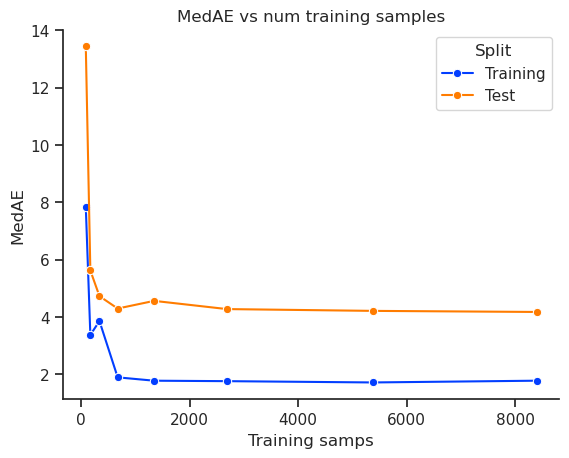

In [45]:
%precision %.2f
pd.set_option('display.float_format', '{:.2f}'.format)
np.set_printoptions(suppress=True) # don't use scientific notation

from epsampling.utils import get_chunks
from epsampling.modeling import get_date_chunked_splits, get_performance
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
random.seed(666)

from tqdm.notebook import tqdm

target_col = 'True_county_inc_deaths_x'

num_weeks_in_chunk = 4

# ## Random split
# from sklearn.model_selection import train_test_split
# df_train, df_test = train_test_split(df, test_size=0.1, 
#                                      random_state=666, shuffle=True)
## Temporal split
chunks = get_chunks(list(df.Date.unique()), num_weeks_in_chunk)
# idx = random.choice(range(len(chunks)))
idx = 5
df_train, df_test = get_date_chunked_splits(df, chunks, idx)

training_fracs = [0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64, 1.]

list_test_dfs = []
list_train_dfs = []
models = {}

for i,s in enumerate(training_fracs):
    
    dff_train = df_train.sample(frac=s,random_state=666)
    
    dff_test = df_test.copy()
    dff_train_for_eval = df_train.copy()
        
    feats =  BASE_PRED_COLS + [x for x in df_acs.columns] 
    X_train = dff_train[feats]
    y_train = dff_train[target_col]

    X_test = dff_test[feats]

    reg = LinearRegression().fit(X_train, y_train)

    dff_test[f'LinReg'] = reg.predict(X_test)
    dff_train_for_eval[f'LinReg'] = reg.predict(dff_train_for_eval[feats])

    list_test_dfs.append(dff_test)
    list_train_dfs.append(dff_train_for_eval)
    models[i] = reg
    
    
## GET PERFORMANCE !
from epsampling.modeling import get_metrics_ser

metrics_sers = []
for l,split in [[list_train_dfs,'Training'], [list_test_dfs,'Test']]:
    
    for i,dff in enumerate(l):
        ser = get_metrics_ser(dff, 
                              target_col='True_county_inc_deaths_x', 
#                               pred_col='LinReg_(True_state_inc_deaths_x)')
                              pred_col='LinReg')
        ser['Training frac'] = training_fracs[i]
        ser['Training samps'] = training_fracs[i] * len(df_train)
        ser['Split'] = split
        ## drop model attr bc only have one
        ser.pop('Model')
        metrics_sers.append(ser)

df_metrics = pd.DataFrame(metrics_sers)

## PLOT !

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1, style='ticks', palette='bright') 
    
sns.lineplot(df_metrics, y='MedAE', x='Training samps', marker='o',hue='Split')
sns.despine()
plt.title(f'MedAE vs num training samples')
plt.show()

In [46]:
display(df_metrics[df_metrics.Split=='Training'],
        df_metrics[df_metrics.Split=='Test'])

,MAE,MedAE,R-squared,MSE,relMAE (Proj),relMAE (True),Training frac,Training samps,Split
0,923247483855.88,7.84,-81052655288984344199168.00,3842117297893267159908352.00,327789264922.78,340462942709.98,0.01,84.00,Training
1,1571068466792.51,3.38,-500198901849290885300224.00,23710794499332914695634944.00,557791260608.15,579357759166.69,0.02,168.00,Training
2,444379526168.90,3.86,-160938639329295715008512.00,7628931191234279858241536.00,157772255843.35,163872378538.91,0.04,336.00,Training
3,10819912231.41,1.89,-246969943821028655104.00,11707050063089830461440.00,3841495524.10,3990023501.38,0.08,672.00,Training
4,2.91,1.78,0.47,25.17,1.03,1.07,0.16,1344.00,Training
5,2.80,1.76,0.49,24.30,1.00,1.03,0.32,2688.00,Training
6,2.76,1.72,0.49,23.96,0.98,1.02,0.64,5376.00,Training
7,2.77,1.78,0.50,23.76,0.98,1.02,1.00,8400.00,Training


,MAE,MedAE,R-squared,MSE,relMAE (Proj),relMAE (True),Training frac,Training samps,Split
8,923247483859.50,13.44,-34273331347367651180544.00,3842117297900792479481856.00,156297713960.39,158081080004.06,0.01,84.00,Test
9,1571068466794.57,5.62,-211510439004312189272064.00,23710794499335221093072896.00,265968133277.48,269002845210.03,0.02,168.00,Test
10,444379526170.55,4.73,-68053332647154664079360.00,7628931191233957735694336.00,75229562263.10,76087935961.73,0.04,336.00,Test
11,10819912234.28,4.30,-104431899081495166976.00,11707050063123189858304.00,1831716389.20,1852616380.17,0.08,672.00,Test
12,5.96,4.56,0.22,87.42,1.01,1.02,0.16,1344.00,Test
13,5.80,4.28,0.23,86.47,0.98,0.99,0.32,2688.00,Test
14,5.81,4.21,0.22,87.69,0.98,0.99,0.64,5376.00,Test
15,5.82,4.18,0.22,87.51,0.99,1.00,1.00,8400.00,Test


In [ ]:
from epsampling.modeling import get_metrics_ser
import matplotlib.pyplot as plt
import seaborn as sns
    
for l,t in [[list_train_dfs,'TRAINING'], [list_test_dfs,'TEST']]:

    metrics_sers = []

    for i,dff in enumerate(l):

        pred_col = 'LinReg_(True_state_inc_deaths_x)'

        ser = get_metrics_ser(dff, 'True_county_inc_deaths_x', pred_col)
        ser['Training frac'] = sizes[i]
        metrics_sers.append(ser)

    df_metrics = pd.DataFrame(metrics_sers)
    
    sns.lineplot(df_metrics, y='MedAE', x='Training frac', marker='o')
    plt.title(f'Eval on {t} set')
    plt.show()
    
    display(df_metrics)

In [ ]:
display(df_metrics)

In [ ]:
# metrics_sers = []

# for i,dff in enumerate(list_train_dfs):

#     pred = 'LinReg_(True_state_inc_deaths_x)'
    
#     ser = get_metrics_ser(dff, 'True_county_inc_deaths_x', pred)
#     ser['Training frac'] = sizes[i]
#     metrics_sers.append(ser)

# df_metrics = pd.DataFrame(metrics_sers)
# display(df_metrics)

# import matplotlib.pyplot as plt
# import seaborn as sns
# sns.lineplot(df_metrics, y='MedAE', x='Training frac', marker='o')
# plt.show()

In [ ]:
# target_col = 'True_county_inc_deaths_x'
# naive_col = 'Naive_proj_deaths_x'
# # naive_col = 'True_county_inc_deaths_x'
# base_pred_col = 'True_state_inc_deaths_x'

# feats =  [base_pred_col] + [x for x in df_acs.columns] 

### <font color=blue> Train model using true state deaths as covariate.

In [ ]:
%precision %.2f
pd.set_option('display.float_format', '{:.2f}'.format)
np.set_printoptions(suppress=True) # don't use scientific notation

from epsampling.utils import get_chunks
from epsampling.modeling import get_date_chunked_splits, get_performance
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
random.seed(666)

from tqdm.notebook import tqdm


target_col = 'True_county_inc_deaths_x'

num_weeks_in_chunk = 4
num_runs = 25
alg = 'LinReg'

chunks = get_chunks(list(df.Date.unique()), num_weeks_in_chunk)
idc = random.sample(range(len(chunks)), num_runs)

test_dfs = []
models = {}

for i,idx in tqdm(enumerate(idc), total=len(idc)):
    
    df_train, df_test = get_date_chunked_splits(df, chunks, idx)
        
    df_test[f'Run'] = i

    for base_pred_col in ['True_state_inc_deaths_x','Proj_state_inc_deaths_x']:
        
        feats =  [base_pred_col] + [x for x in df_acs.columns] 
        X_train = df_train[feats]
        y_train = df_train[target_col]

        X_test = df_test[feats]

        reg = LinearRegression().fit(X_train, y_train)

        df_test[f'{alg}_({base_pred_col})'] = reg.predict(X_test)
        

    test_dfs.append(df_test)
    models[i] = reg

In [ ]:
# %precision %.2f
# pd.set_option('display.float_format', '{:.2f}'.format)
# np.set_printoptions(suppress=True) # don't use scientific notation

# from epsampling.utils import get_chunks
# from epsampling.modeling import get_date_chunked_splits, get_performance
# from sklearn import linear_model
# from sklearn.linear_model import LinearRegression
# random.seed(666)

# from tqdm.notebook import tqdm

# target_col = 'True_county_inc_deaths_x'
# alg = 'LinReg'

# for base_pred_col in ['True_state_inc_deaths_x','Proj_state_inc_deaths_x']:

#     feats =  [base_pred_col] + [x for x in df_acs.columns] 
#     X_train = df[feats]
#     y_train = df[target_col]

#     reg = LinearRegression().fit(X_train, y_train)

#     df[f'{alg}_({base_pred_col})'] = reg.predict(X_train)

In [ ]:
df

In [ ]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)

df_res = pd.concat(test_dfs)
df_res.drop(df_acs.columns,axis=1,inplace=True)
df_res

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error

def get_metrics_ser(df, target_col, pred_col):
    
    metrics_dict = {'MAE': mean_absolute_error,
                    'MedAE': median_absolute_error,
                    'MSE': mean_squared_error,
                    'RMSE': mean_squared_error,
                    'r2': r2_score
                    }
    
    mae = mean_absolute_error(df[target_col], df[pred_col])
    medae = median_absolute_error(df[target_col], df[pred_col])
    r2 = r2_score(df[target_col], df[pred_col])
    mse = mean_squared_error(df[target_col], df[pred_col])
    
    # relMAE to naive_true
    relmae_true = mae / mean_absolute_error(df[target_col],df['Naive_true_deaths_x'])
    # relMAE to naive_proj
    relmae_proj = mae / mean_absolute_error(df[target_col],df['Naive_proj_deaths_x'])
    
    ser = {'Model':pred, 'MAE':mae, 'MedAE':medae, 
           'R-squared':r2, 'MSE': mse, 'relMAE (Proj)': relmae_proj, 
           'relMAE (True)': relmae_true}
    
    return ser
    
    
metrics_sers = []

for pred in ['LinReg_(True_state_inc_deaths_x)', 'LinReg_(Proj_state_inc_deaths_x)', 
             'Naive_true_deaths_x','Naive_proj_deaths_x',]:
    
    ser = get_metrics_ser(df_res, 'True_county_inc_deaths_x', pred)
    metrics_sers.append(ser)

df_metrics = pd.DataFrame(metrics_sers)

### <font color=blue> Per county performance.

In [ ]:
metrics_sers = []

# for fips in df_res.Fips.unique():
#     subdf = df_res[df_res.Fips==fips]
for fips in df_res.Fips.unique():
    subdf = df_res[df_res.Fips==fips]
    for pred in ['LinReg_(True_state_inc_deaths_x)', 'LinReg_(Proj_state_inc_deaths_x)', 
                 'Naive_true_deaths_x','Naive_proj_deaths_x',]:
        
        ser = get_metrics_ser(subdf, 'True_county_inc_deaths_x', pred)
    
        ser['Fips'] = fips
        ser['Pop'] = subdf.Pop.values[0]
    
        metrics_sers.append(ser)
    
df_county = pd.DataFrame(metrics_sers)
df_county

In [ ]:
df_melt = pd.melt(df_county, id_vars=['Fips','Pop','Model'], 
                  value_vars=['MAE', 'MedAE', 'R-squared','MSE','relMAE (Proj)','relMAE (True)'], 
                  var_name='Metric', value_name='Score')
df_melt['Metric'] = df_melt.Metric.apply(lambda x: f'{x}\n')
# model_dict = {'LinReg_(True_state_inc_deaths_x)':'LinReg (True)',
#               'LinReg_(Proj_state_inc_deaths_x)': 'LinReg (Proj)', 
#               'Naive_true_deaths_x':'Naive (True)',
#               'Naive_proj_deaths_x': 'Naive (Proj)'}
# df_melt['Model'] = df_melt.Model.apply(lambda x: model_dict[x])

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1, style='ticks') 

g = sns.FacetGrid(df_melt, col='Model', row="Metric", sharey='row') #, margin_titles=True)
g.map(plt.scatter, 'Pop','Score', alpha=0.8, s=5).set(xscale='log')
g.set_titles(col_template='{col_name}', row_template='{row_name}',)

for i, axes_row in enumerate(g.axes):
    for j, axes_col in enumerate(axes_row):
        row, col = axes_col.get_title().split('|')
        if i == 0:
            axes_col.set_title(col.strip())
        else:
            axes_col.set_title('')
        if j == 0:
            ylabel = axes_col.get_ylabel()
            axes_col.set_ylabel(row.strip())

plt.show()

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# sns.set(font_scale=1, style='ticks') 

# from matplotlib import ticker as mtick

# metric = 'R-squared'
# model = 'Naive_true_deaths_x'
# # FIGSIZE = (8,6)
# FIGSIZE = (6,6)

# ALPHA = 0.5
# SIZE = 30
# LINEWIDTH = 0
# DPI = 100
# LABELPAD = 8
  
# plt.figure(figsize=FIGSIZE)
# # ax = sns.scatterplot(data=df_tot, x="Pop", y=metric, alpha=ALPHA, 
# #                      sizes=SIZES, linewidth=LINEWIDTH,hue='Is_state',hue_order=[True,False])

# plt_df = df_county[df_county.Model==model]
# ax = sns.scatterplot(data=plt_df, x="Pop", y=metric, alpha=ALPHA, 
#                      s=SIZE, linewidth=LINEWIDTH,
#                      c='blue',
#                      marker='.')

# # sns.scatterplot(data=df_tot[df_tot.Is_state==True], x="Pop", y=metric, alpha=0.8, 
# #                      s=80, linewidth=0.5, edgecolor='w', c='red',ax=ax, marker='*',)

# plt.xlabel('Population\n (log scale)',labelpad=LABELPAD)
# # plt.ylabel('MAE (population normed)')
# # plt.ylabel(' Mean absolute error\n(normed by population)', labelpad=LABELPAD)
# plt.ylabel(f'{metric}', labelpad=LABELPAD)

# # plt.xt

# plt.xscale('log')
# xticks = mtick.FormatStrFormatter('%d')
# plt.gca().xaxis.set_major_formatter(xticks)

# ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

# sns.despine()
# plt.gcf().set_dpi(DPI)
# plt.show()